In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dython import nominal
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import pickle
from sklearn import tree
import graphviz
from lime import lime_tabular
import shap
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical

In [2]:
data_dir = './data/'

In [3]:
models_dir = './models/'

In [4]:
models_dict = {'linear regression': 'linear_regression', 
               'decision tree regression': 'decision_tree_regression',
               'support vector regression': 'support_vector_regression',
               'long short-term memory regression': 'long_short_term_memory_regression.h5'}

In [5]:
regression_data = pd.read_csv(data_dir+'regression_data.csv', index_col=[0])

In [6]:
regression_data.shape

(1197, 28)

In [7]:
regression_data = regression_data.sort_values(by=['date', 'team', 'department']).reset_index(drop=True)

In [8]:
dep_var = ['targeted_productivity']

In [9]:
regression_data

date  department  team  targeted_productivity    smv     wip  \
0     2015-01-01  finishing      1                   0.75   3.94     0.0   
1     2015-01-01      sweing     1                   0.75  28.08   681.0   
2     2015-01-01  finishing      2                   0.75   3.94     0.0   
3     2015-01-01      sweing     2                   0.75  19.88   733.0   
4     2015-01-01      sweing     3                   0.75  28.08   795.0   
...          ...         ...   ...                    ...    ...     ...   
1192  2015-03-11      sweing    10                   0.75  21.81  1674.0   
1193  2015-03-11   finishing    11                   0.80   2.90     0.0   
1194  2015-03-11      sweing    11                   0.80  11.41   560.0   
1195  2015-03-11   finishing    12                   0.80   4.60     0.0   
1196  2015-03-11      sweing    12                   0.80  15.26   470.0   

      over_time  incentive  idle_time  idle_men  ...  \
0           960          0        0.0         0  ...   
1          6900         45        0.0         0  ...   
2           960          0        0.0         0  ...   
3          6000         34        0.0         0  ...   
4          6900         45        0.0         0  ...   
...         ...        ...        ...       ...  ...   
1192       6000         34        0.0         0  ...   
1193       2400          0        0.0         0  ...   
1194       3420         50        0.0         0  ...   
1195       2160          0        0.0         0  ...   
1196       4080         63        0.0         0  ...   

      targeted_productivity_rmean_1_1  targeted_productivity_rmean_2_1  \
0                                0.00                             0.00   
1                                0.75                             0.00   
2                                0.00                             0.00   
3                                0.75                             0.00   
4                                0.00                             0.00   
...                               ...                              ...   
1192                             0.70                             0.75   
1193                             0.80                             0.80   
1194                             0.80                             0.80   
1195                             0.80                             0.80   
1196                             0.80                             0.80   

      targeted_productivity_rmean_1_2  targeted_productivity_rmean_2_2  \
0                               0.000                            0.000   
1                               0.375                            0.000   
2                               0.000                            0.000   
3                               0.375                            0.000   
4                               0.000                            0.000   
...                               ...                              ...   
1192                            0.725                            0.725   
1193                            0.800                            0.800   
1194                            0.800                            0.800   
1195                            0.800                            0.800   
1196                            0.800                            0.800   

      actual_productivity_lag_2  actual_productivity_lag_4  \
0                        0.0000                     0.0000   
1                        0.0000                     0.0000   
2                        0.0000                     0.0000   
3                        0.0000                     0.0000   
4                        0.0000                     0.0000   
...                         ...                        ...   
1192                     0.7505                     0.7000   
1193                     0.8000                     0.9604   
1194                     0.7583                     0.8000   
1195                     0.9

In [10]:
categorical = np.array(['department', 'team'])
continuous = np.setdiff1d(np.setdiff1d(regression_data.columns,categorical), dep_var)

In [11]:
continuous = continuous[continuous != 'date']

In [12]:
X = regression_data.loc[:,np.union1d(categorical, continuous)]

In [13]:
y = regression_data.loc[:,dep_var]*100

In [14]:
test_idx = int((0.2*len(X)))

In [15]:
X_train, X_test, y_train, y_test = X.iloc[:len(X)- test_idx, :], X.iloc[len(X)- test_idx:, :], y.iloc[:len(y)- test_idx, :], y.iloc[len(y)- test_idx:, :]

In [16]:
# We need to encode only categorical variables
enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
X_train.loc[:, categorical] = enc.fit_transform(X_train[categorical])
X_test.loc[:, categorical] = enc.transform(X_test[categorical])

y_train = y_train.values.flatten()
y_test = y_test.values.flatten()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
feature_names = X_train.columns

In [18]:
feature_names

Index(['actual_productivity', 'actual_productivity_lag_2',
       'actual_productivity_lag_4', 'actual_productivity_rmean_2_1',
       'actual_productivity_rmean_2_2', 'actual_productivity_rmean_4_1',
       'actual_productivity_rmean_4_2', 'department', 'dow', 'idle_men',
       'idle_time', 'incentive', 'month', 'no_of_style_change',
       'no_of_workers', 'over_time', 'smv', 'targeted_productivity_lag_1',
       'targeted_productivity_lag_2', 'targeted_productivity_rmean_1_1',
       'targeted_productivity_rmean_1_2', 'targeted_productivity_rmean_2_1',
       'targeted_productivity_rmean_2_2', 'team', 'week', 'wip'],
      dtype='object')

## Linear Regression

#### Functions

In [19]:
def importance_plot(model, X_test, X_train=None, y_train=None, model_type='linearregression', title='Importance Plot', title_size=25, axes_size=15, tick_size=12):
    fig, ax = plt.subplots(figsize=(12, 10))
    if model_type == 'linearregression':
        input_x = model['rfe'].fit_transform(X_train, y_train)
        ranking = model['rfe'].ranking_
        input_x = loaded_linear_regression['standardscaler'].fit_transform(input_x)
        model = model[model_type]
        trained_model = model.fit(input_x, y_train)
        Y = trained_model.coef_
        all_columns = X_train.columns.to_list()
        X = []
        for elem in all_columns:
            if ranking[all_columns.index(elem)] == 1:
                X.append(elem)
    elif model_type == 'decisiontreeregressor':
        model = model[model_type]
        X = X_test.columns
        Y = model.feature_importances_
    df = pd.DataFrame({'X': X, 'Y': Y, 'abs_Y': abs(Y)})
    df = df.sort_values(by='abs_Y')
    ax.barh(df['X'], df['Y'])
    plt.title(title, fontsize=title_size,  y=1.02)
    ax.set_xlabel('Importance Coefficients', fontsize=axes_size)
    ax.set_ylabel('Data Features', fontsize=axes_size)
    plt.show()   

In [20]:
def plot_difference(y_test, predictions_test, title='Scatter plot', title_size=25, axes_size=15, tick_size=12, acc = 'valid_accuracy'):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.scatter(y_test, predictions_test)
    min_y = y_test.min()
    min_predictions = predictions_test.min()
    min_val = np.minimum(min_y, min_predictions)
    ax.axline((min_val, min_val), slope=1, color='black')   
    
    acc_label = acc.split('_')[0]
    fig.suptitle(title + f' for expected vs predicted output', fontsize=title_size,  y=1.02)
    ax.set_xlabel('Expected output', fontsize=axes_size)
    ax.set_ylabel('Predicted output', fontsize=axes_size)
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

In [21]:
loaded_linear_regression = pickle.load(open(models_dir+models_dict['linear regression'], 'rb'))

In [22]:
loaded_linear_regression

Pipeline(steps=[('rfe',
                 RFE(estimator=LinearRegression(), n_features_to_select=6)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [23]:
linear_regression_predictions = loaded_linear_regression.predict(X_test)

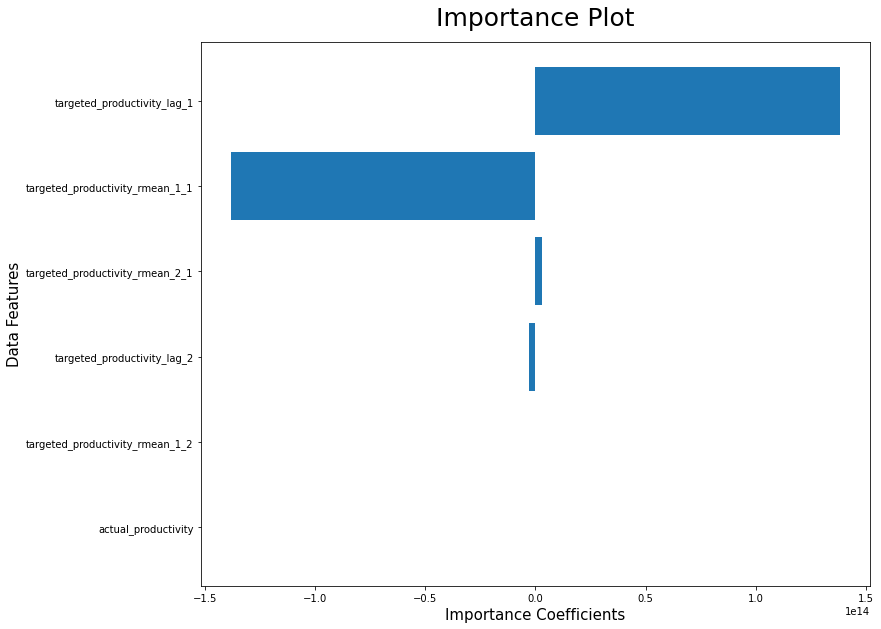

In [24]:
importance_plot(loaded_linear_regression, X_test, X_train, y_train, model_type='linearregression')

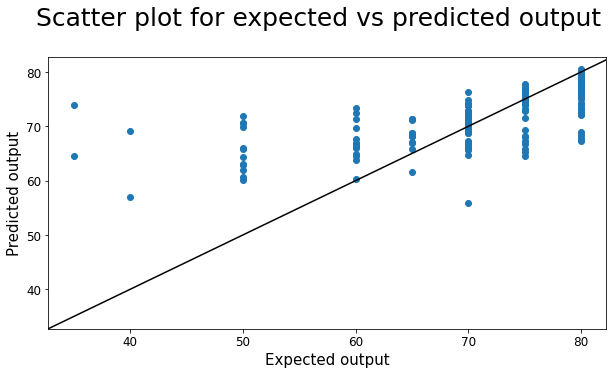

In [25]:
plot_difference(y_test, loaded_linear_regression.predict(X_test))

## Decision Tree Regression

In [83]:
def visualise_tree(model, X_train, model_type='decisiontreeclassifier'):
    # Visualising the decision tree
    decision_tree = tree.export_graphviz(model[model_type], out_file='trees/tree_reg.dot', feature_names=X_train.columns, filled=True)

    with open("trees/tree_reg.dot") as f:
        dot_graph = f.read()
    src = graphviz.Source(dot_graph, format='png')
    return src

In [27]:
loaded_decision_tree_regression = pickle.load(open(models_dir+models_dict['decision tree regression'], 'rb'))

In [28]:
decision_tree_regression_predictions = loaded_decision_tree_regression.predict(X_test)

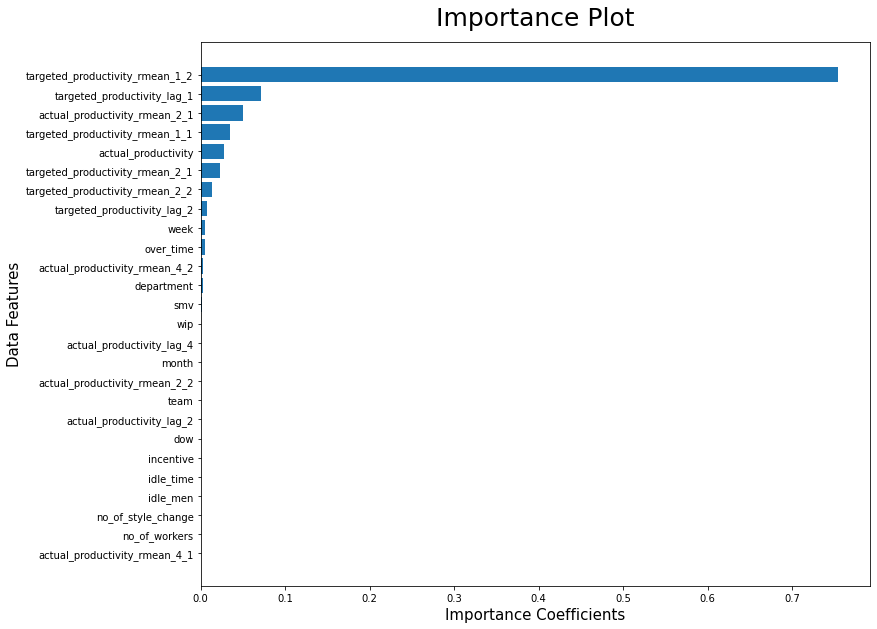

In [29]:
importance_plot(loaded_decision_tree_regression, X_test, model_type='decisiontreeregressor')

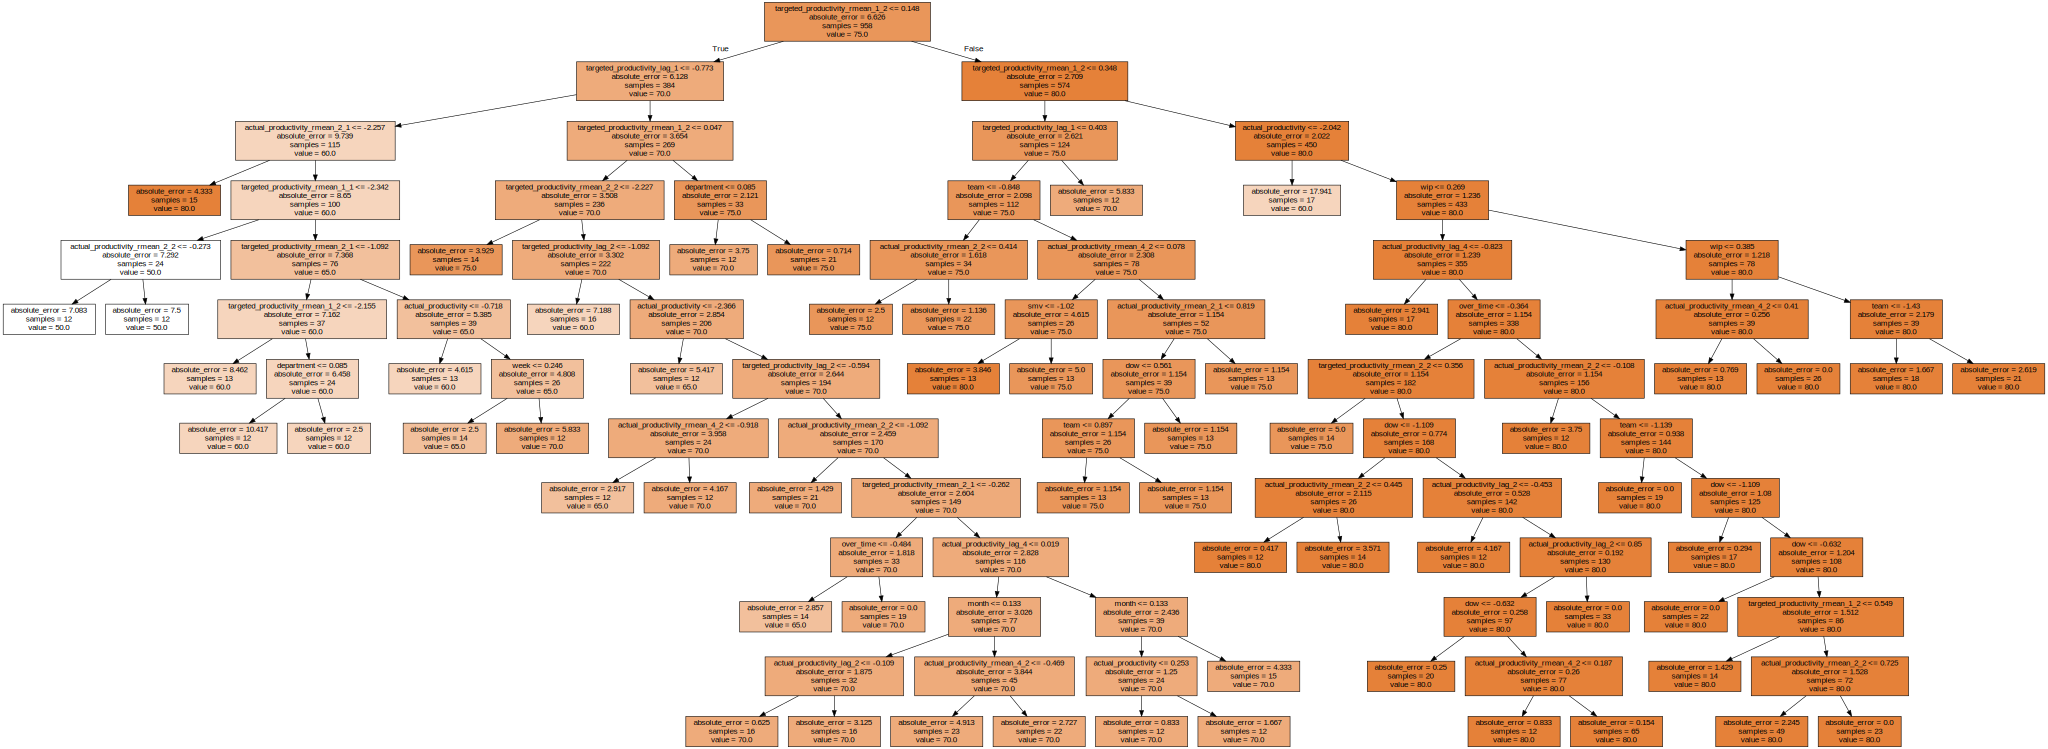

In [84]:
visualise_tree(loaded_decision_tree_regression, X_train, model_type='decisiontreeregressor')

In [77]:
!pip install pydotplus

You should consider upgrading via the 'd:\uni\masters\diss\diss\scripts\python.exe -m pip install --upgrade pip' command.



  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24567 sha256=f4a2c316a69bc5703bd0c434f47b4647d713514a5be5097e14ca5c696910ff7c
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\fe\cd\78\a7e873cc049759194f8271f780640cf96b35e5a48bef0e2f36
Successfully built pydotplus


In [78]:
import pydotplus

## Support Vector Regression

In [79]:
# Export resulting tree to DOT source code string
dot_data = export_graphviz(clf,
                           feature_names=X_test.columns,
                           out_file=None,
                           filled=True,
                           rounded=True)

#Export to pdf
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_pdf('tree.pdf')

True

In [31]:
loaded_support_vector_regression = pickle.load(open(models_dir+models_dict['support vector regression'], 'rb'))

In [32]:
support_vector_regression_predictions = loaded_support_vector_regression.predict(X_test)

In [33]:
loaded_support_vector_regression

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=30, epsilon=0.001, gamma='auto'))])

### Lime

#### Local Interpretation

#### Explain a single prediction from the test set

In [34]:
predicted_row = np.random.randint(0, X_test.shape[0])
predicted_row

86

In [35]:
num_features =  np.random.randint(5, len(X_test.columns))
num_features

17

In [36]:
explainer_svm_lime = lime_tabular.LimeTabularExplainer(X_train, 
                                                       mode='regression',
                                                       feature_names=X_train.columns.to_list(),
                                                       discretize_continuous=False
                                                      )

In [37]:
exp = explainer_svm_lime.explain_instance(X_test.iloc[predicted_row], 
                                          loaded_support_vector_regression.predict, 
                                          num_features=num_features, 
                                          top_labels=1)

X does not have valid feature names, but StandardScaler was fitted with feature names


In [38]:
y_test[predicted_row]

80.0

In [39]:
exp.show_in_notebook(show_table=True, show_all=False)

#### Global Interpretation

------------

## SHAP

In [40]:
shap.initjs()

In [41]:
predicted_row

86

In [42]:
sample_X_data =  X_train.iloc[0:100, :]

In [43]:
sample_y_data =  y_train[0:100]

In [44]:
explainer_svm_shap = shap.KernelExplainer(loaded_support_vector_regression.predict, sample_X_data)

X does not have valid feature names, but StandardScaler was fitted with feature names


In [45]:
shap_values_svm = explainer_svm_shap.shap_values(X_test, nsamples=100)

  0%|          | 0/239 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' wi

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

#### Local Interpretation

### Partial Plot

In [46]:
y_test[predicted_row]

80.0

In [47]:
explainer_svm_shap.expected_value

77.41046739815633

In [48]:
shap.force_plot(explainer_svm_shap.expected_value, shap_values_svm[predicted_row], X_test.iloc[predicted_row,:])

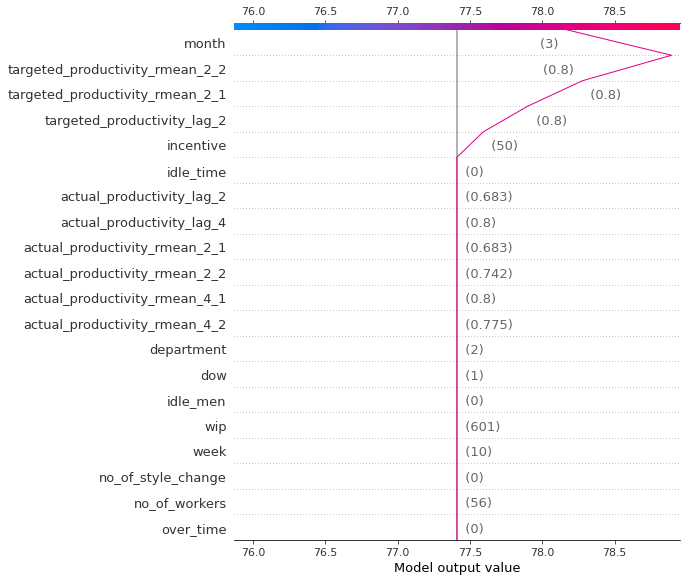

In [49]:
shap.decision_plot(
    base_value=explainer_svm_shap.expected_value,
    shap_values=shap_values_svm[predicted_row],
    features=X_test.iloc[predicted_row],
    feature_names=X_test.columns.tolist(),
    link="identity",
)

### Global Plots

In [50]:
shap.force_plot(explainer_svm_shap.expected_value, shap_values_svm, X_test, link="logit")

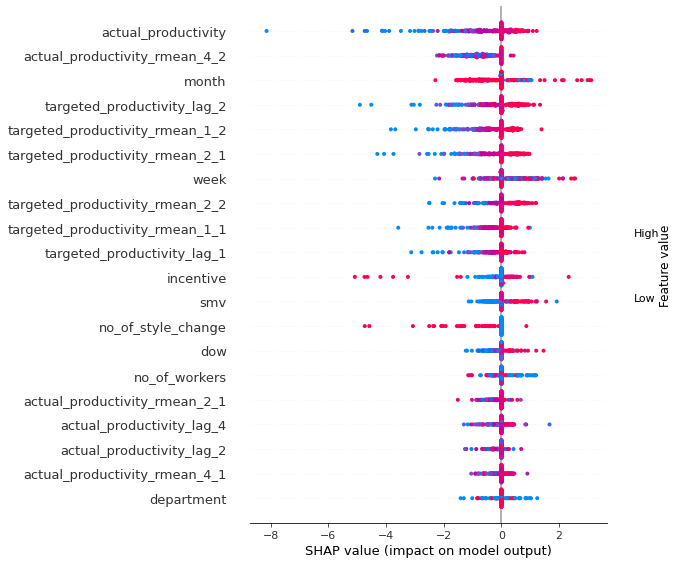

In [51]:
shap.summary_plot(shap_values = shap_values_svm,
                  features = X_test,
                  feature_names=X_train.columns
                  )

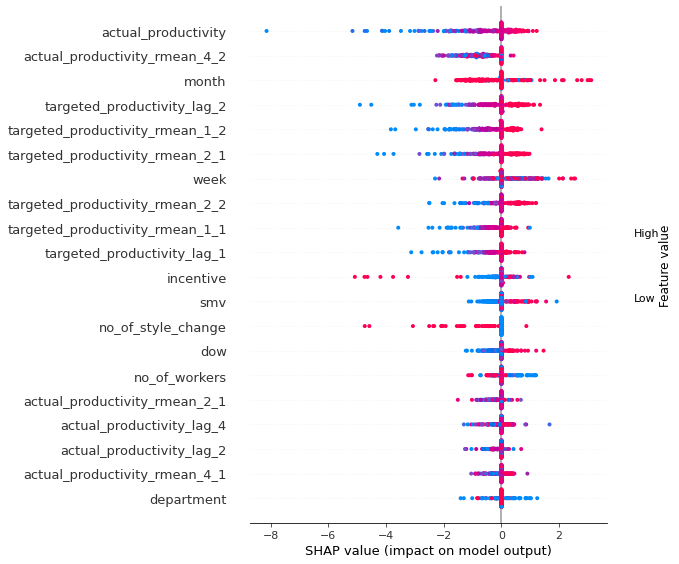

In [52]:
shap.summary_plot(shap_values_svm,
                  features = X_test,
                  plot_type='dot',
                  feature_names=X_train.columns)

## Long short-term memory regression

In [53]:
def build_model_LSTM(input_shape, hid_layer_nums = 1, units=100):
    # LSTM model
    model = Sequential()

    # First LSTM layer with Dropout regularisation
    model.add(LSTM(units=units, 
                   kernel_regularizer=keras.regularizers.l2(0.001), 
                   return_sequences=True, 
                   kernel_initializer='random_normal',
                   bias_initializer='zeros',
                   input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Hidden LSTM layers
    for hid_layer_num in range(hid_layer_nums-1):
        model.add(LSTM(units=units, 
                       kernel_regularizer=keras.regularizers.l2(0.001), 
                       return_sequences=True))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

    # Last LSTM layer
    model.add(LSTM(units=units, 
                   kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # The output layer
    model.add(Dense(units=1, activation='sigmoid'))

    return model

In [54]:
X_test

actual_productivity  actual_productivity_lag_2  \
958                0.7505                     0.9707   
959                0.4110                     0.7000   
960                0.7000                     0.8457   
961                0.8003                     0.5050   
962                0.5910                     0.8003   
...                   ...                        ...   
1192               0.7505                     0.7505   
1193               0.8740                     0.8000   
1194               0.8000                     0.7583   
1195               0.9230                     0.9200   
1196               0.8003                     0.8003   

      actual_productivity_lag_4  actual_productivity_rmean_2_1  \
958                      0.7270                         0.9707   
959                      0.4712                         0.7000   
960                      0.9023                         0.8457   
961                      0.7505                         0.5050   
962                      0.8003                         0.8003   
...                         ...                            ...   
1192                     0.7000                         0.7505   
1193                     0.9604                         0.8000   
1194                     0.8000                         0.7583   
1195                     0.9030                         0.9200   
1196                     0.8003                         0.8003   

      actual_productivity_rmean_2_2  actual_productivity_rmean_4_1  \
958                          0.8354                         0.7270   
959                          0.7730                         0.4712   
960                          0.6580                         0.9023   
961                          0.6280                         0.7505   
962                          0.8496                         0.8003   
...                             ...                            ...   
1192                         0.6140                         0.7000   
1193                         0.8000                         0.9604   
1194                         0.7793                         0.8000   
1195                         0.8604                         0.9030   
1196                         0.8604                         0.8003   

      actual_productivity_rmean_4_2  department  dow  idle_men  ...    smv  \
958                          0.5493         2.0    3         0  ...  18.80   
959                          0.6865         0.0    3         0  ...   2.90   
960                          0.6600         2.0    3         0  ...  21.81   
961                          0.7114         2.0    3         0  ...  11.61   
962                          0.8003         0.0    3         0  ...   4.60   
...                             ...         ...  ...       ...  ...    ...   
1192                         0.5710         2.0    2         0  ...  21.81   
1193                         0.8580         0.0    2         0  ...   2.90   
1194                         0.8800         2.0    2         0  ...  11.41   
1195                         0.8516         0.0    2         0  ...   4.60   
1196                         0.8516         2.0    2         0  ...  15.26   

      targeted_productivity_lag_1  targeted_productivity_lag_2  \
958                          0.70                         0.75   
959                          0.70                         0.70   
960                          0.70                         0.70   
961                          0.75                         0.70   
962                          0.80                         0.80   
...                           ...                          ...   
1192                         0.70                         0.75   
1193                         0.80                         0.80   
1194                         0.80                         0.80   
1195                         0.80                         0.80   
1196                         0.80   

In [55]:
X_train

actual_productivity  actual_productivity_lag_2  \
0                 0.8867                     0.0000   
1                 0.7505                     0.0000   
2                 0.7554                     0.0000   
3                 0.7530                     0.0000   
4                 0.7540                     0.0000   
..                   ...                        ...   
953               0.7505                     0.7505   
954               0.8010                     0.8003   
955               0.3767                     0.6587   
956               0.7500                     0.7000   
957               0.4077                     0.4110   

     actual_productivity_lag_4  actual_productivity_rmean_2_1  \
0                       0.0000                         0.0000   
1                       0.0000                         0.0000   
2                       0.0000                         0.0000   
3                       0.0000                         0.0000   
4                       0.0000                         0.0000   
..                         ...                            ...   
953                     0.7505                         0.7505   
954                     0.3564                         0.8003   
955                     0.7007                         0.6587   
956                     0.7915                         0.7000   
957                     0.7000                         0.4110   

     actual_productivity_rmean_2_2  actual_productivity_rmean_4_1  \
0                           0.0000                         0.0000   
1                           0.0000                         0.0000   
2                           0.0000                         0.0000   
3                           0.0000                         0.0000   
4                           0.0000                         0.0000   
..                             ...                            ...   
953                         0.7390                         0.7505   
954                         0.7754                         0.3564   
955                         0.6797                         0.7007   
956                         0.7000                         0.7915   
957                         0.6910                         0.7000   

     actual_productivity_rmean_4_2  department  dow  idle_men  ...    smv  \
0                           0.0000         1.0    3         0  ...   3.94   
1                           0.0000         2.0    3         0  ...  28.08   
2                           0.0000         1.0    3         0  ...   3.94   
3                           0.0000         2.0    3         0  ...  19.88   
4                           0.0000         2.0    3         0  ...  28.08   
..                             ...         ...  ...       ...  ...    ...   
953                         0.5610         2.0    3         0  ...  18.80   
954                         0.5537         2.0    3         0  ...  30.10   
955                         0.7460         0.0    3         0  ...   4.60   
956                         0.7460         2.0    3         0  ...  29.40   
957                         0.7140         0.0    3         0  ...   2.90   

     targeted_productivity_lag_1  targeted_productivity_lag_2  \
0                           0.00                         0.00   
1                           0.75                         0.00   
2                           0.00                         0.00   
3                           0.75                         0.00   
4                           0.00                         0.00   
..                           ...                          ...   
953                         0.75                         0.75   
954                         0.75                         0.80   
955                         0.75                         0.70   
956                         0.70                         0.70   
957                         0.75                         0.70   

     targeted_productivity_r

In [56]:
from tensorflow import keras

In [57]:
# # Scale the data        
# scaler_x = preprocessing.StandardScaler()
# X_train = scaler_x.fit_transform(X_train)
# X_test = scaler_x.transform(X_test)

# scaler_y = preprocessing.StandardScaler()
# y_train_transformed = scaler_y.fit_transform(y_train.reshape(-1,1))
# y_test_transformed = scaler_y.transform(y_test.reshape(-1,1))

# Reshape the data
X_train_transformed = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_transformed = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

In [58]:
input_shape = (X_train_transformed.shape[1], X_train_transformed.shape[2])

In [59]:
loaded_lstm_regression = build_model_LSTM(input_shape, hid_layer_nums = 5, units=64)
loaded_lstm_regression.load_weights(models_dir+models_dict['long short-term memory regression'])

In [60]:
loaded_lstm_regression_predictions = np.argmax(loaded_lstm_regression.predict(X_test_transformed), axis=1)

### Lime

#### Local Interpretation

In [61]:
explainer_lstm_lime = lime_tabular.RecurrentTabularExplainer(X_train_transformed, 
                                                             mode='regression',
                                                             feature_names=feature_names,
                                                            )

In [62]:
exp = explainer_lstm_lime.explain_instance(X_test_transformed[predicted_row].reshape(-1,1,X_test_transformed[predicted_row].shape[0]), 
                                           loaded_lstm_regression.predict, 
                                           num_features=num_features,
                                           labels=(1,)
                                          )

In [63]:
predicted_row

86

In [64]:
y_test[predicted_row]

80.0

In [65]:
exp.show_in_notebook()